# Build a Mobile Document Scanner

[build-kick-ass-mobile-document-scanner-just-5-minutes](https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)，scan.py

the imutils `module` contains convenience functions for resizing, rotating and cropping images（make performing basic image processing operations easier）. You can read more about imutils in [this post](https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/).  
import the `threshold_local` function from scikit-image. This function will help us obtain the “black and white” feel to our scanned image.

In [ ]:
from transform import four_point_transform
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils

In [2]:
def display1(img, name, isGray=True, size=(6,8)):
    plt.figure(figsize=size) # (w,h)
    if isGray==True:
        plt.imshow(img, cmap='gray')
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    
    plt.xticks([]), plt.yticks([]) # 隐藏x轴和y轴
    plt.title(name)
    plt.show()


def display2(img, name):
    while True:
        cv2.imshow(name, img)
        key = cv2.waitKey(0)
        if key == ord('q'):
            break
    cv2.destroyAllWindows()


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # construct two thresholds using the median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    print("lower:", lower, "upper:", upper)

    # return the edged image
    return edged

### 1、Edge Detection

Building document scanner app using OpenCV is to perform edge detection.

1. In order to speedup image processing, as well as make edge detection more accurate, resize image to have a height of 500 pixels .

2. Also keep track of the ratio of the original height of the image to the new height — this will allow us to perform the scan on the original image rather than the resized image.

3. Convert the image from RGB to grayscale, perform Gaussian blurring to remove high frequency noise (aiding in contour detection), and perform Canny edge detection.

In [3]:
# 给图像边缘添加黑色边框，用于书脊图片
def add_border(img, pxl=10):
    h, w, c = img.shape
    new_shape = (h+2*pxl, w+2*pxl, c)
    dst = np.zeros(new_shape, np.uint8)

    for i in range(0, h):
        for j in range(0, w):
            dst[i+pxl,j+pxl] = img[i,j]

    return dst

lower: 46 upper: 93


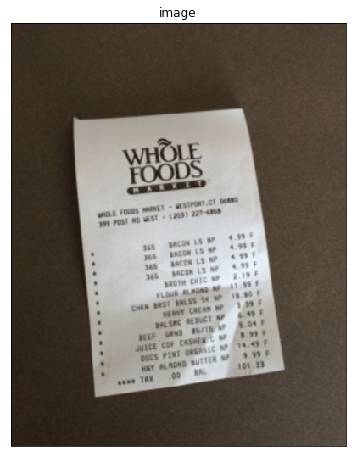

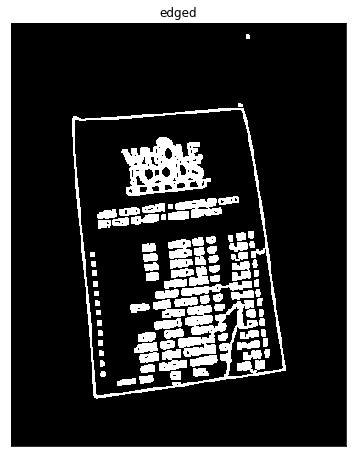

In [6]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread('receipt.png')
# image = add_border(img)
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)

# 边缘不够明显，则使用拉普拉斯算子对边缘进行锐化
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
Sharp = cv2.filter2D(image, -1, kernel=kernel)

# convert the image to grayscale, blur it, and find edges
gray = cv2.cvtColor(Sharp, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# edged = cv2.Canny(gray, 75, 200)
edged = auto_canny(gray)

# 膨胀，使不闭合轮廓闭合
edged = cv2.dilate(edged, None, iterations=1)

# show the original image and the edge detected image
display1(image, 'image', isGray=False)
display1(edged, 'edged')

### 2: Contour detection

A document scanner simply scans in a piece of paper. A piece of paper is assumed to be a rectangle. And a rectangle has four edges. Therefore, we can create a simple heuristic to help us build our document scanner.

Assume that the largest contour in the image with exactly four points is our piece of paper to be scanned.

The scanner app simply assumes that the document you want to scan is the main focus of our image, and the piece of paper has four edges.

1. A neat performance hack is actually sort the contours by area and keep only the largest ones. This only examine the largest of the contours, discarding the rest.

2. Loop over the contours and approximate the number of points. If the approximated contour has four points, and found the document in the image.

3. The scanner app will assume that (1) the document to be scanned is the main focus of the image and (2) the document is rectangular, and thus will have four distinct edges.

ssss
dddd


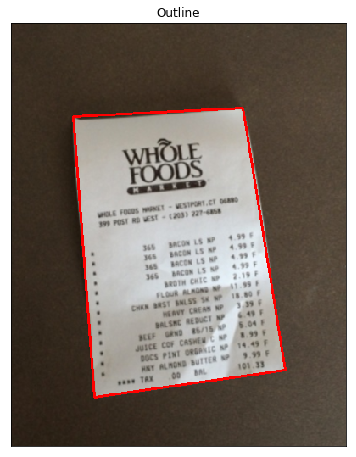

In [11]:
# find contours in the edged image, only keep the largest one.
# edged is a binary image, the output is tuple (image, cnts, hierarchy)
(_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(len(cnts))     # 该图中总的轮廓数量
# print(cnts[0])       # 第一个轮廓所有点的坐标
# print(hierarchy)     # 打印出所有轮廓之间的关系
# 根据轮廓面积排序（从大到小）
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
    # 计算轮廓周长，True表示轮廓闭合
    peri = cv2.arcLength(c, True)
    # 用由更少点组成的轮廓去逼近原轮廓,简化了轮廓中的点数，使其成为“更基本”的几何形状
    # 新轮廓的点数由设定的精度来决定，即点之间的距离小于等于指定的精度
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    try:
        # if approximated contour has four points, found the screen
        if len(approx) == 4:
            screenCnt = approx
            break
    except UnboundLocalError:
        print("local variable 'screenCnt' referenced before assignment")

# show the contour (outline) of the piece of paper
cv2.drawContours(image, [screenCnt], -1, (0, 0, 255), 2)
display1(image, 'Outline', isGray=False)

### 3: 4 Point getPerspective Transform

[4-point-opencv-getperspective-transform-example](https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/)，transform.py

### 4: Apply a Perspective Transform & Threshold

Building a document scanner is to take the four points representing the outline of the document and apply a perspective transform to obtain a top-down, 90-degree “birds eye view” of the image.

1. Pass two arguments into four_point_transform : the first is original image loaded off disk (not the resized one), and the second argument is the contour representing the document, multiplied by the resized ratio.

2. Multiplying by the resized ratio is because we performed edge detection and found contours on the resized image of *height=500* pixels. However, we want to perform the scan on the original image, not the resized image, thus multiply the contour points by the resized ratio.

3. To obtain the nice, clean black and white feel to the image, we take the warped image, convert it to grayscale and apply adaptive thresholding.

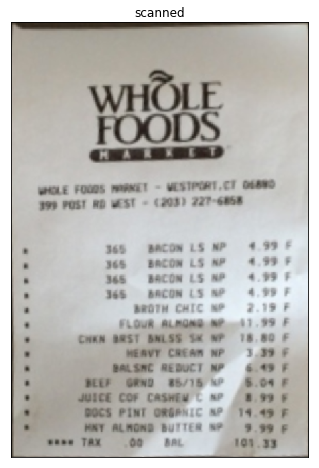

In [13]:
# apply the perspective transform to obtain a top-down view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# # threshold it to give it that 'black and white' paper effect
# T = threshold_local(warped, 11, offset = 10, method = "gaussian")
# warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
display1(imutils.resize(warped, height = 650), 'scanned', isGray=False)

### Summary

Document scanning can be broken down into three distinct and simple steps.

* The first step is to apply edge detection.

* The second step is to find the contours in the image that represent the document we want to scan.

* The final step is to apply a perspective transform to obtain a top-down, 90-degree view of the image, just as if we scanned the document.

Optionally, you can also apply thresholding to obtain a nice, clean black and white feel to the piece of paper.


Now you can build a mobile document scanner, maybe you should to build an app and submit to the App Store yourself!

Another great “next step” would be to apply OCR to the documents in the image. Not only could you scan the document and generate a PDF, but you would be able to edit the text as well!